In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Model
from keras.layers import *

import segmentation_models as sm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

Segmentation Models: using `tf.keras` framework.


### Exploratory Data Analysis

(-0.5, 3023.5, 3023.5, -0.5)

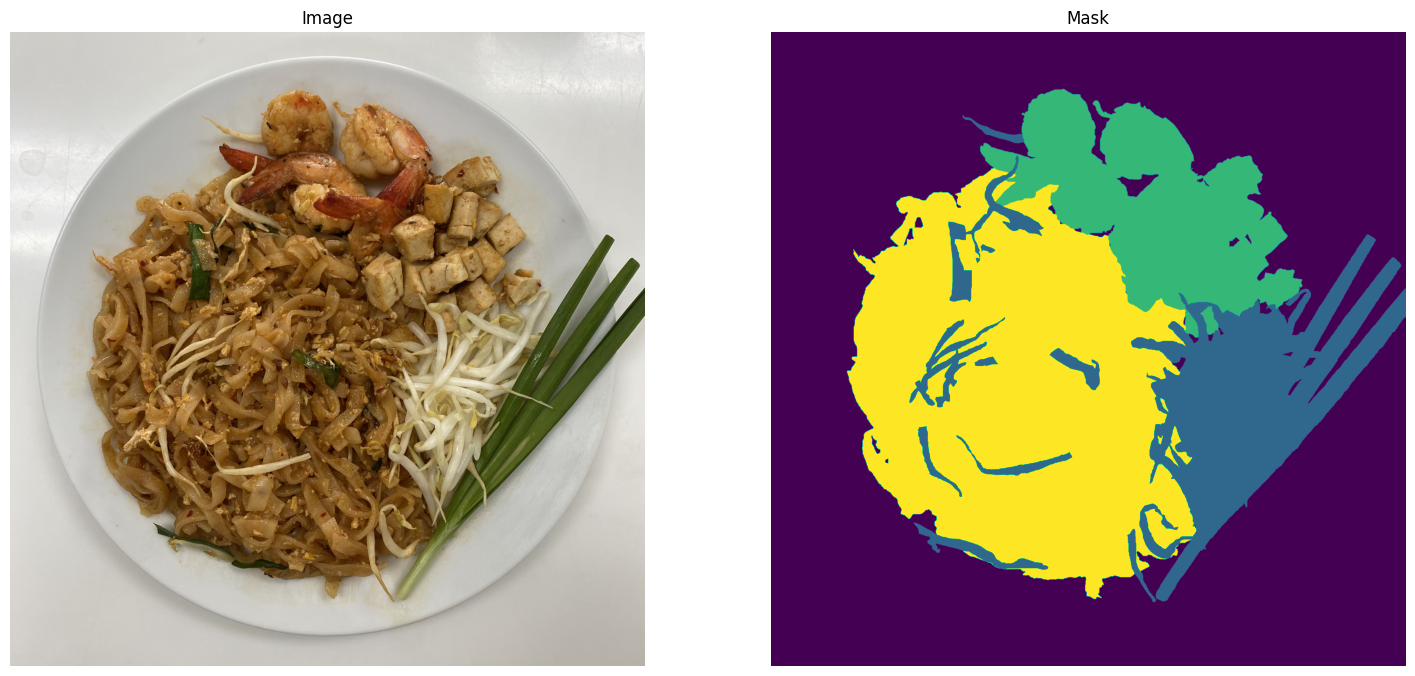

In [3]:
index = input('Image index: ')
if len(index) == 1:
    index = '0' + str(index)
example_img = cv2.imread(f'./Data/Images/5/I0{index}/0{index}-1.jpg', 1)
example_mask = cv2.imread(f'./Data/Masks/5/L0{index}/L0{index}-1.png', 0)

plt.figure(figsize=(18, 12))

plt.subplot(121)
plt.imshow(cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(example_mask)
plt.title('Mask')
plt.axis('off')

In [4]:
def calculateProportion(mask):
    segment_areas = {}
    segment = [1, 2, 3]
    categories = ['Vegetable', 'Protein', 'Carbohydrate']

    for label in np.unique(mask):
        area = np.sum(mask == label)
        segment_areas[label] = area

    
    segment_areas = {key: segment_areas[key] for key in segment}

    total_area = sum(segment_areas.values())

    for label, area in segment_areas.items():
        proportion = area / total_area
        print(f'{categories[label-1]} Proportion = {proportion:.4f}')

In [5]:
calculateProportion(example_mask)

Vegetable Proportion = 0.2492
Protein Proportion = 0.2150
Carbohydrate Proportion = 0.5358


### Load Data

In [7]:
def loadImageAndMask():
    X_size = 128
    y_size = 128
    X_train = []
    X_val = []
    X_test = []
    y_train = []
    y_val = []
    y_test = []
    for i in range(0, len([f for f in os.listdir(f'C:\GitHub\Senior_Project\Senior Project\Data\Images\\5') if f != '.DS_Store'])):
        index = i + 1
        if len(str(index)) == 1:
            index = '0' + str(index)
        else:
            index = str(index)

        for j in range(len([f for f in os.listdir(f'C:\GitHub\Senior_Project\Senior Project\Data\Images\\5\I0{index}') if f != '.DS_Store'])):
            img = cv2.imread(f'./Data/Images/5/I0{index}/0{index}-{j+1}.jpg', 1)
            mask = cv2.imread(f'./Data/Masks/5/L0{index}/L0{index}-{j+1}.png', 0)
            img = cv2.resize(img, (y_size, X_size))
            mask = cv2.resize(mask, (y_size, X_size))
            
            if i <= len([f for f in os.listdir(f'C:\GitHub\Senior_Project\Senior Project\Data\Images\\5') if f != '.DS_Store']) - 3:
                X_train.append(img)
                y_train.append(mask)
            elif i <= len([f for f in os.listdir(f'C:\GitHub\Senior_Project\Senior Project\Data\Images\\5') if f != '.DS_Store']) - 2:
                X_val.append(img)
                y_val.append(mask)
            else:
                X_test.append(img)
                y_test.append(mask)
            
    X_train = np.array(X_train)
    X_train = X_train / 255
    X_val = np.array(X_val)
    X_val = X_val / 255
    X_test = np.array(X_test)
    X_test = X_test / 255
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    return X_train, X_val, X_test, y_train, y_val, y_test 


In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = loadImageAndMask()
print(f'Image array shape: {X_train.shape} --> Type: {type(X_train)}')
print(f'Image array shape: {X_val.shape} --> Type: {type(X_test)}')
print(f'Image array shape: {X_test.shape} --> Type: {type(X_test)}')
print(f'Mask array shape: {y_train.shape} --> Type: {type(y_train)}')
print(f'Mask array shape: {y_val.shape} --> Type: {type(y_test)}')
print(f'Mask array shape: {y_test.shape} --> Type: {type(y_test)}')

Image array shape: (70, 128, 128, 3) --> Type: <class 'numpy.ndarray'>
Image array shape: (10, 128, 128, 3) --> Type: <class 'numpy.ndarray'>
Image array shape: (10, 128, 128, 3) --> Type: <class 'numpy.ndarray'>
Mask array shape: (70, 128, 128) --> Type: <class 'numpy.ndarray'>
Mask array shape: (10, 128, 128) --> Type: <class 'numpy.ndarray'>
Mask array shape: (10, 128, 128) --> Type: <class 'numpy.ndarray'>


### Pre-Processing Data

In [9]:
np.unique(y_train)

array([0, 1, 2, 3], dtype=uint8)

In [10]:
n_classes = 4

def labelEncoder(masks):
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    mask_reshaped = masks.reshape(-1, 1)
    mask_reshaped_encoded = labelencoder.fit_transform(mask_reshaped)
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(mask_reshaped_encoded), y=mask_reshaped_encoded)
    mask_categorized = mask_reshaped_encoded.reshape(n, h, w)
    return mask_categorized, class_weights

In [11]:
y_train, class_weights = labelEncoder(y_train)
y_val, _ = labelEncoder(y_val)
y_test, _ = labelEncoder(y_test)

print(np.unique(y_train))
print(class_weights)

c:\Users\patin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3]
[0.4182134  1.8603444  3.15368032 1.32581765]


c:\Users\patin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\patin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
y_train = np.expand_dims(y_train, axis=3)
y_val = np.expand_dims(y_val, axis=3)
y_test = np.expand_dims(y_test, axis=3)

In [13]:
def oneHotEncoder(masks):
    mask_categorical = to_categorical(masks, num_classes=n_classes)
    mask_categorized = mask_categorical.reshape(masks.shape[0], masks.shape[1], masks.shape[2], n_classes)
    return mask_categorized

In [14]:
y_train = oneHotEncoder(y_train)
y_val = oneHotEncoder(y_val)
y_test = oneHotEncoder(y_test)

Categorical Shape: (70, 128, 128, 4)

['Other', 'Vegetable', 'Protein', 'Carbohydrate']
First Pixel Categorized: [1. 0. 0. 0.]
Middle Pixel Categorized: [0. 0. 0. 1.]


(-0.5, 3023.5, 3023.5, -0.5)

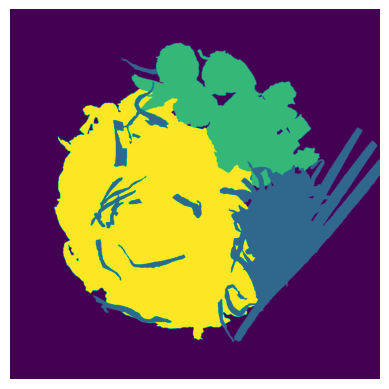

In [15]:
print(f'Categorical Shape: {y_train.shape}\n')
print("['Other', 'Vegetable', 'Protein', 'Carbohydrate']")
print(f'First Pixel Categorized: {y_train[0][0][0]}')
print(f'Middle Pixel Categorized: {y_train[11][64][64]}')
plt.imshow(example_mask)
plt.axis('off')

In [16]:
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (70, 128, 128, 3)
X_test Shape: (10, 128, 128, 3)
y_train Shape: (70, 128, 128, 4)
y_test Shape: (10, 128, 128, 4)


### Modeling

In [17]:
n_classes = 4
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [18]:
def unet_vgg16(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
   
    c1 = Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(inputs)
    c1 = Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c1)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.3)(p1)

    c2 = Conv2D(128, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(p1)
    c2 = Conv2D(128, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c2)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.3)(p2)

    c3 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(p2)
    c3 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c3)
    c3 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c3)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.3)(p3)

    c4 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(p3)
    c4 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c4)
    c4 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c4)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.3)(p4)

    c5 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(p4)
    c5 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c5)
    c5 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c5)

    c6 = Conv2DTranspose(512, 3, 2, padding = "same")(c5)
    c6 = concatenate([c6, c4])
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c6)
    c6 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c6)
    c6 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c6)

    c7 = Conv2DTranspose(256, 3, 2, padding = "same")(c6)
    c7 = concatenate([c7, c3])
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c7)
    c7 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c7)
    c7 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c7)
    
    c8 = Conv2DTranspose(128, 3, 2, padding = "same")(c7)
    c8 = concatenate([c8, c2])
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(128, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c8)
    c8 = Conv2D(128, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c8)

    c9 = Conv2DTranspose(64, 3, 2, padding = "same")(c8)
    c9 = concatenate([c9, c1])
    c9 = Dropout(0.3)(c9)
    c9 = Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c9)
    c9 = Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c9)

    outputs = Conv2D(n_classes, 1, padding = "same", activation = "softmax")(c9)

    unet_model = Model(inputs, outputs)

    return unet_model

In [24]:
model = unet_vgg16(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_25 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_24[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_25[0][0]']           
 g2D)                                                                                       

In [26]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = sm.metrics.IOUScore(threshold=0.5)

model.compile(optimizer='adam', loss=total_loss, metrics=[metrics])

In [27]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/model_checkpoint.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', patience=40, mode='max', restore_best_weights=True)
]

In [28]:
history = model.fit(X_train, y_train, batch_size=X_train.shape[0], verbose=1, epochs=500, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
1/1 [==============================] - 60s 60s/step - loss: 0.7687 - iou_score: 0.0330 - val_loss: 0.7868 - val_iou_score: 0.1430
Epoch 2/500
1/1 [==============================] - 53s 53s/step - loss: 0.7829 - iou_score: 0.1415 - val_loss: 0.7306 - val_iou_score: 0.1553
Epoch 3/500
1/1 [==============================] - 53s 53s/step - loss: 0.7306 - iou_score: 0.1575 - val_loss: 0.6670 - val_iou_score: 0.1640
Epoch 4/500
1/1 [==============================] - 53s 53s/step - loss: 0.6818 - iou_score: 0.1468 - val_loss: 0.6927 - val_iou_score: 0.1037
Epoch 5/500
1/1 [==============================] - 53s 53s/step - loss: 0.8092 - iou_score: 0.0843 - val_loss: 0.6025 - val_iou_score: 0.1678
Epoch 6/500
1/1 [==============================] - 53s 53s/step - loss: 0.6301 - iou_score: 0.1782 - val_loss: 0.5989 - val_iou_score: 0.1627
Epoch 7/500
1/1 [==============================] - 55s 55s/step - loss: 0.6172 - iou_score: 0.1746 - val_loss: 0.5503 - val_iou_score: 0.1682
Epoch 

In [29]:
model.save('../Models/ผัดไทย.h5')

### Evaluation

In [30]:
_, IoU = model.evaluate(X_test, y_test)
print(f'Iou Score = {IoU}')

1/1 [==============================] - 3s 3s/step - loss: -0.5237 - iou_score: 0.8726
Iou Score = 0.8725540637969971


In [31]:
history.history.keys()

dict_keys(['loss', 'iou_score', 'val_loss', 'val_iou_score'])

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
iou_score = history.history['iou_score']
val_iou_score = history.history['val_iou_score']
epochs = range(1, len(loss) + 1 - 20)

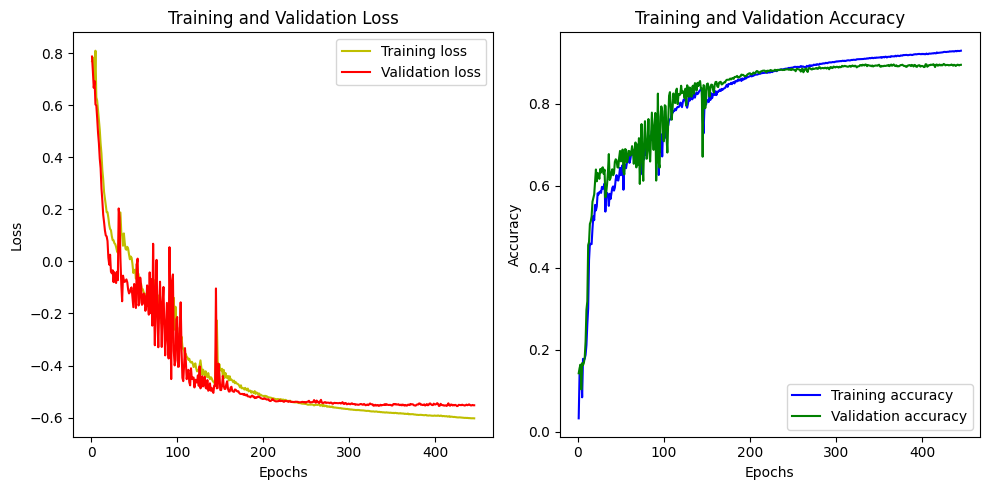

In [35]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss[:-20], 'y', label='Training loss')
plt.plot(epochs, val_loss[:-20], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, iou_score[:-20], 'b', label='Training accuracy')
plt.plot(epochs, val_iou_score[:-20], 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Result Visualization

In [36]:
def preprocessInputImage(input_img):
    X_size = 128
    y_size = 128
    image = []
    input_img = cv2.resize(input_img, (y_size, X_size))
    image.append(input_img)          
    image = np.array(image)
    image = image / 255
    return image

In [37]:
def feedInput2Model(model_input_image):
    prediction = (model.predict(model_input_image))
    prediction_image = np.argmax(prediction, axis=3)[0]
    return prediction_image

(3024, 3024, 3)
(3024, 3024)
1/1 [==============================] - 2s 2s/step
(128, 128)


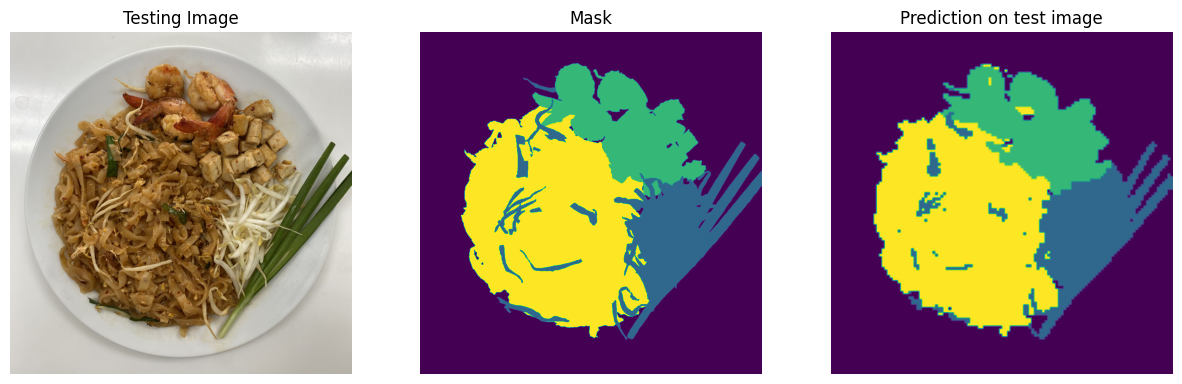

In [38]:
index = input('Image index: ')
if len(index) == 1:
    index = '0' + str(index)
input_img = cv2.imread(f'./Data/Images/5/I0{index}/0{index}-1.jpg', 1)
input_mask = cv2.imread(f'./Data/Masks/5/L0{index}/L0{index}-1.png', 0)
input_img_plot = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
print(input_img.shape)
print(input_mask.shape)
prediction_image = feedInput2Model(preprocessInputImage(input_img))
print(prediction_image.shape)

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(input_img_plot)
plt.axis('off')

plt.subplot(232)
plt.title('Mask')
plt.imshow(input_mask)
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_image)
plt.axis('off')
plt.show()

In [ ]:
def calculateProportion(mask):
    segment_areas = {}
    segment = [1, 2, 3]
    categories = ['Vegetable', 'Protein', 'Carbohydrate']

    for label in segment:
        area = np.sum(mask == label)
        segment_areas[label] = area

    
    segment_areas = {key: segment_areas[key] for key in segment}

    total_area = sum(segment_areas.values())

    for label, area in segment_areas.items():
        proportion = area / total_area
        print(f'{categories[label-1]} Proportion = {proportion:.4f}')

In [ ]:
print('\nPrediction proportion:')
calculateProportion(input_mask)

print('\nPrediction proportion:')
calculateProportion(prediction_image)


Prediction proportion:
Vegetable Proportion = 0.4895
Protein Proportion = 0.2068
Carbohydrate Proportion = 0.3037

Prediction proportion:
Vegetable Proportion = 0.4943
Protein Proportion = 0.3346
Carbohydrate Proportion = 0.1712
